In [1]:
import torch
from src.simple_baseline import BaselineModel
from src.simple_dataset import OCRDataset
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from tqdm.notebook import tqdm
from torchmetrics.text import WordErrorRate, CharErrorRate
import numpy as np
import os

# deterministic
_ = pl.seed_everything(42)
_ = np.random.seed(42)
_ = torch.manual_seed(42)

Seed set to 42


In [2]:
def train_and_eval_for_subset(subset=2):
    ds = OCRDataset(subset=subset)
    
    # Split train and validation
    random_ordered_indices = torch.randperm(len(ds))
    train_indices = random_ordered_indices[:int(len(ds)*0.8)]
    val_indices = random_ordered_indices[int(len(ds)*0.8):]
    train_ds, val_ds = torch.utils.data.Subset(ds, train_indices), torch.utils.data.Subset(ds, val_indices)
    
    sample_img, _ = train_ds[0]
    plt.imshow(sample_img.permute(1, 2, 0).numpy())
    plt.show()
    
    model = BaselineModel(n_chars=len(ds.chars), seq_len=ds.subset, idx2char=ds.idx2char)
    
    train_dl = torch.utils.data.DataLoader(
        train_ds, batch_size=16,
        shuffle=True, num_workers=5,
        pin_memory=False,
    )

    val_dl = torch.utils.data.DataLoader(
            val_ds, batch_size=16,
            shuffle=False, num_workers=5,
            pin_memory=False,
        )
    
    tensorboard_logger = pl.loggers.TensorBoardLogger('./logs/', name=f'baseline-{subset}-{np.random.randint(1000)}')
    
    trainer = pl.Trainer(
        max_epochs=10,
        devices=1,
        accelerator='gpu',
        min_epochs=5,
        deterministic=True,
        logger=tensorboard_logger
    )

    trainer.fit(model, train_dl, val_dl)
    
    model = model.to('cpu')
    model.eval()
    
    results = []
    orig = []
    for (val_img, val_enc) in tqdm(val_ds):
        outp = model(val_img.view(1, 3, 64, 128))
        outp = ''.join([str(val) for val in outp.argmax(-1).detach().numpy()[0].tolist()])
        results.append(outp)
        orig.append(''.join([str(val) for val in val_enc.argmax(-1).detach().numpy().tolist()]))
    
    # Add WER and CER metrics
    wer = WordErrorRate()
    cer = CharErrorRate()
    
    word_error_rate = wer(orig, results)
    char_error_rate = cer(orig, results)
    
    return {'original': orig, 'predicted': results, 'word_error_rate': word_error_rate, 'char_error_rate': char_error_rate, 'paths': ds.df['file_path'].values[val_indices]}


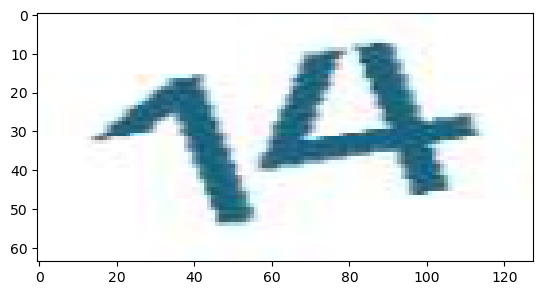

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params
--------------------------------------------
0 | model     | Sequential    | 1.6 M 
1 | wer       | WordErrorRate | 0     
2 | cer       | CharErrorRate | 0     
3 | valid_wer | WordErrorRate | 0     
4 | valid_cer | CharErrorRate | 0     
--------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.329     Total estimated model params size (MB)


Sanity Checking: |                                                                | 0/? [00:00<?, ?it/s]

Training: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/376 [00:00<?, ?it/s]

In [3]:
res2 = train_and_eval_for_subset(2)

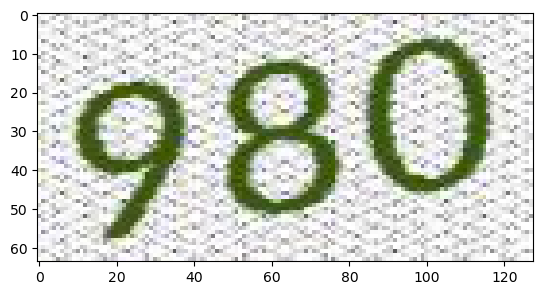

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params
--------------------------------------------
0 | model     | Sequential    | 1.6 M 
1 | wer       | WordErrorRate | 0     
2 | cer       | CharErrorRate | 0     
3 | valid_wer | WordErrorRate | 0     
4 | valid_cer | CharErrorRate | 0     
--------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.350     Total estimated model params size (MB)


Sanity Checking: |                                                                | 0/? [00:00<?, ?it/s]

Training: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/348 [00:00<?, ?it/s]

In [4]:
res3 = train_and_eval_for_subset(3)

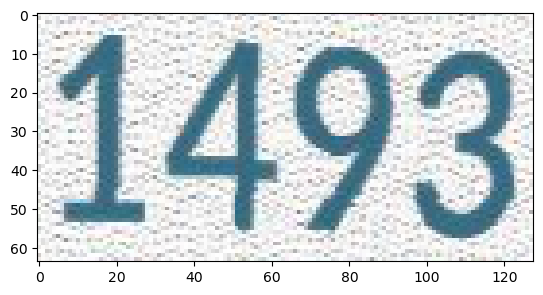

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params
--------------------------------------------
0 | model     | Sequential    | 1.6 M 
1 | wer       | WordErrorRate | 0     
2 | cer       | CharErrorRate | 0     
3 | valid_wer | WordErrorRate | 0     
4 | valid_cer | CharErrorRate | 0     
--------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.370     Total estimated model params size (MB)


Sanity Checking: |                                                                | 0/? [00:00<?, ?it/s]

Training: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/356 [00:00<?, ?it/s]

In [5]:
res4 = train_and_eval_for_subset(4)

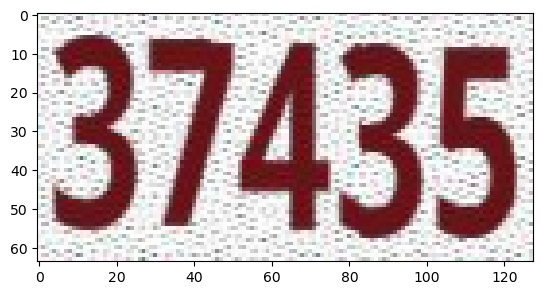

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params
--------------------------------------------
0 | model     | Sequential    | 1.6 M 
1 | wer       | WordErrorRate | 0     
2 | cer       | CharErrorRate | 0     
3 | valid_wer | WordErrorRate | 0     
4 | valid_cer | CharErrorRate | 0     
--------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.391     Total estimated model params size (MB)


Sanity Checking: |                                                                | 0/? [00:00<?, ?it/s]

Training: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/347 [00:00<?, ?it/s]

In [6]:
res5 = train_and_eval_for_subset(5)

In [7]:
def plot_errors(res, subset):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
    axes = axes.flatten()
    image_ind, ax_ind = 0, 0
    while ax_ind < 9 and image_ind < len(res['predicted']):
        if res['predicted'][image_ind] != res['original'][image_ind]:
            axes[ax_ind].imshow(plt.imread(os.path.join('./data', res['paths'][image_ind])))
            axes[ax_ind].set_title(f'Original: {res["original"][image_ind]}, Predicted: {res["predicted"][image_ind]}')
            axes[ax_ind].axis('off')
            ax_ind += 1
        image_ind += 1
    plt.suptitle(f"Subset {subset} | WER: {res['word_error_rate']:.3f} | CER: {res['char_error_rate']:.3f}")
    plt.tight_layout()
    plt.show()

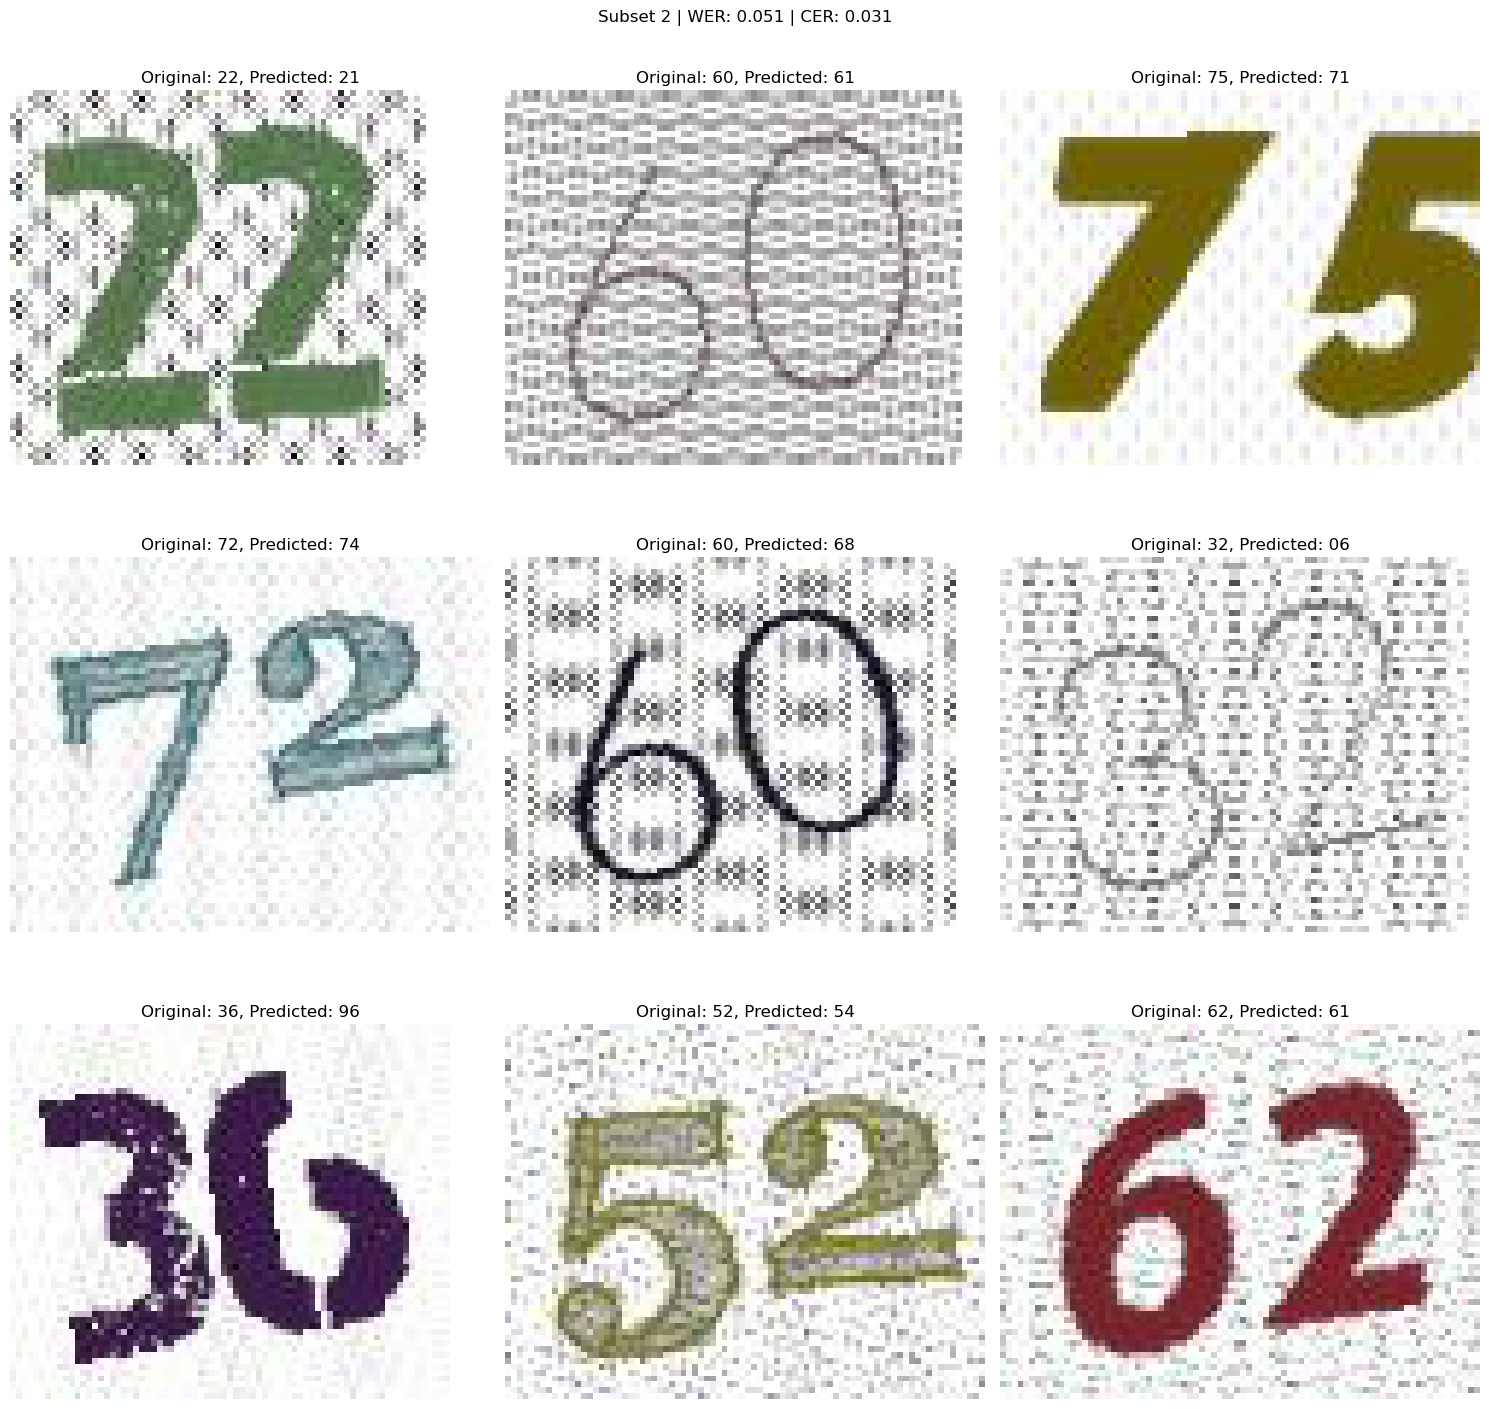

In [8]:
plot_errors(res2, 2)

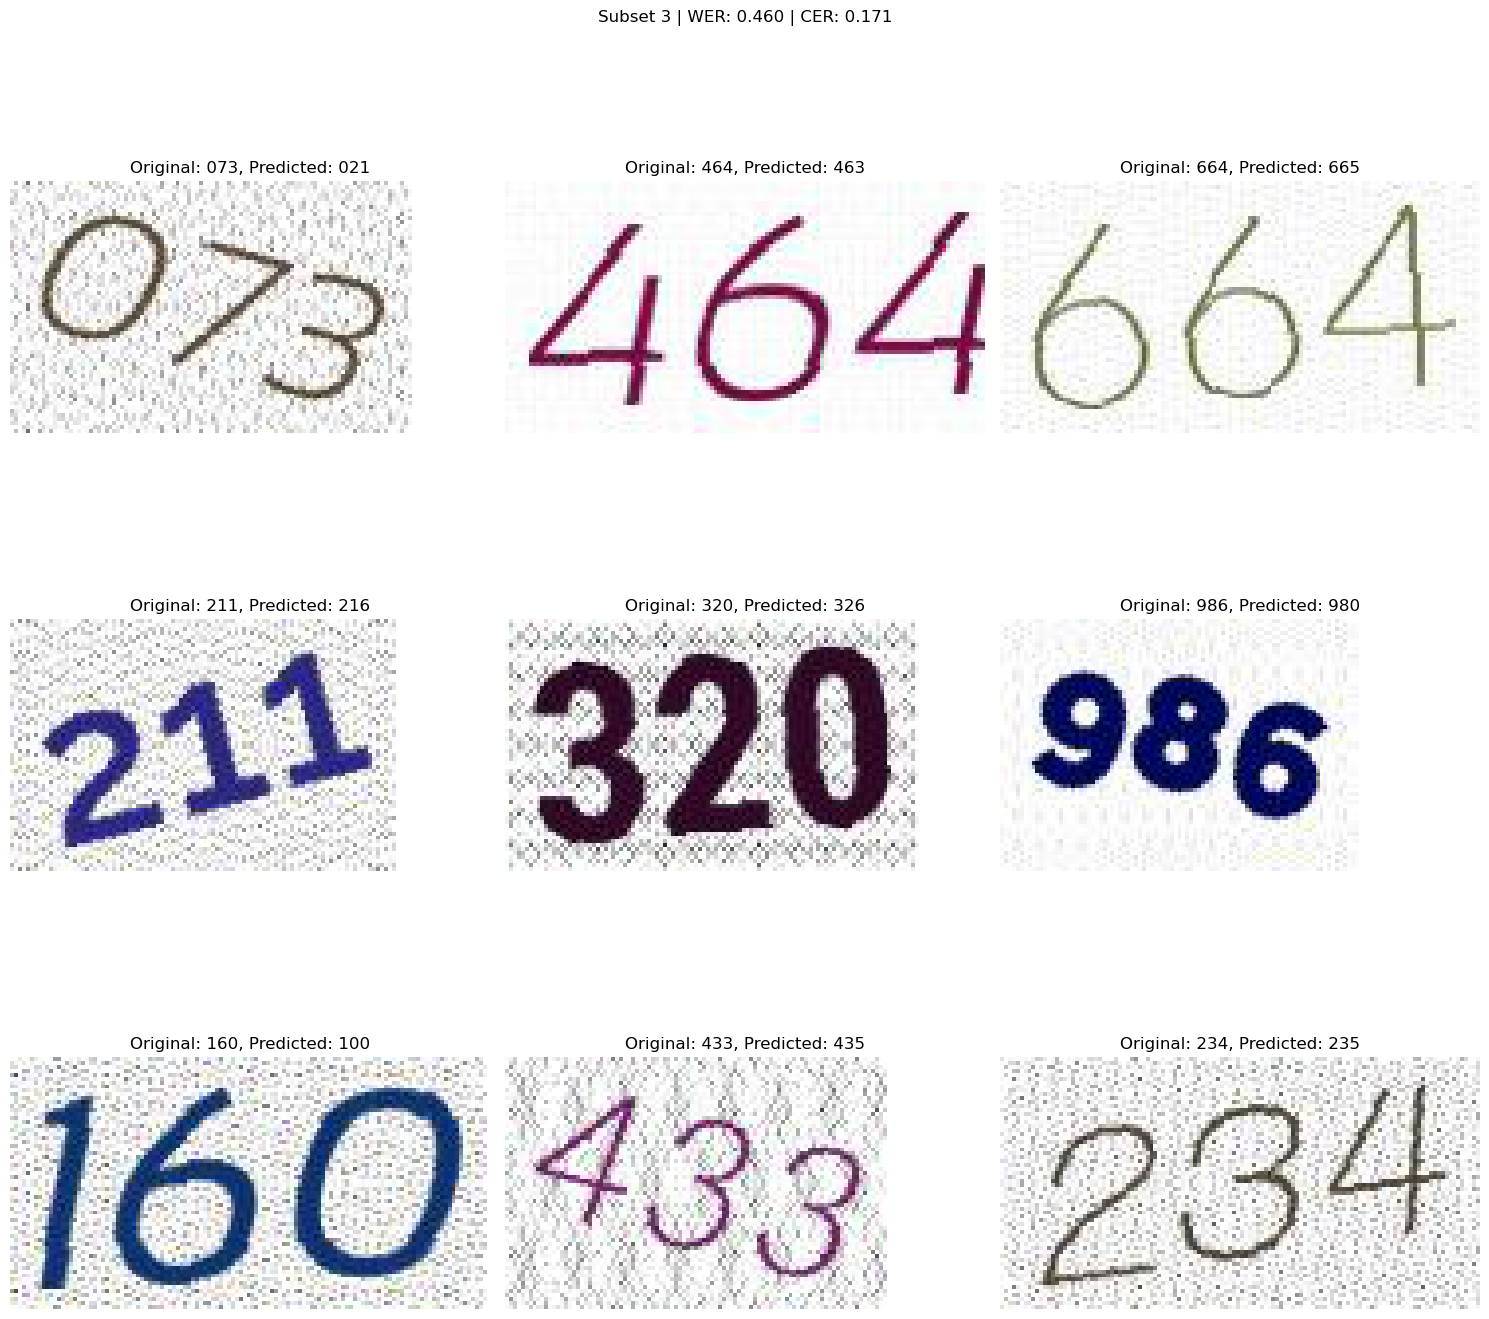

In [9]:
plot_errors(res3, 3)

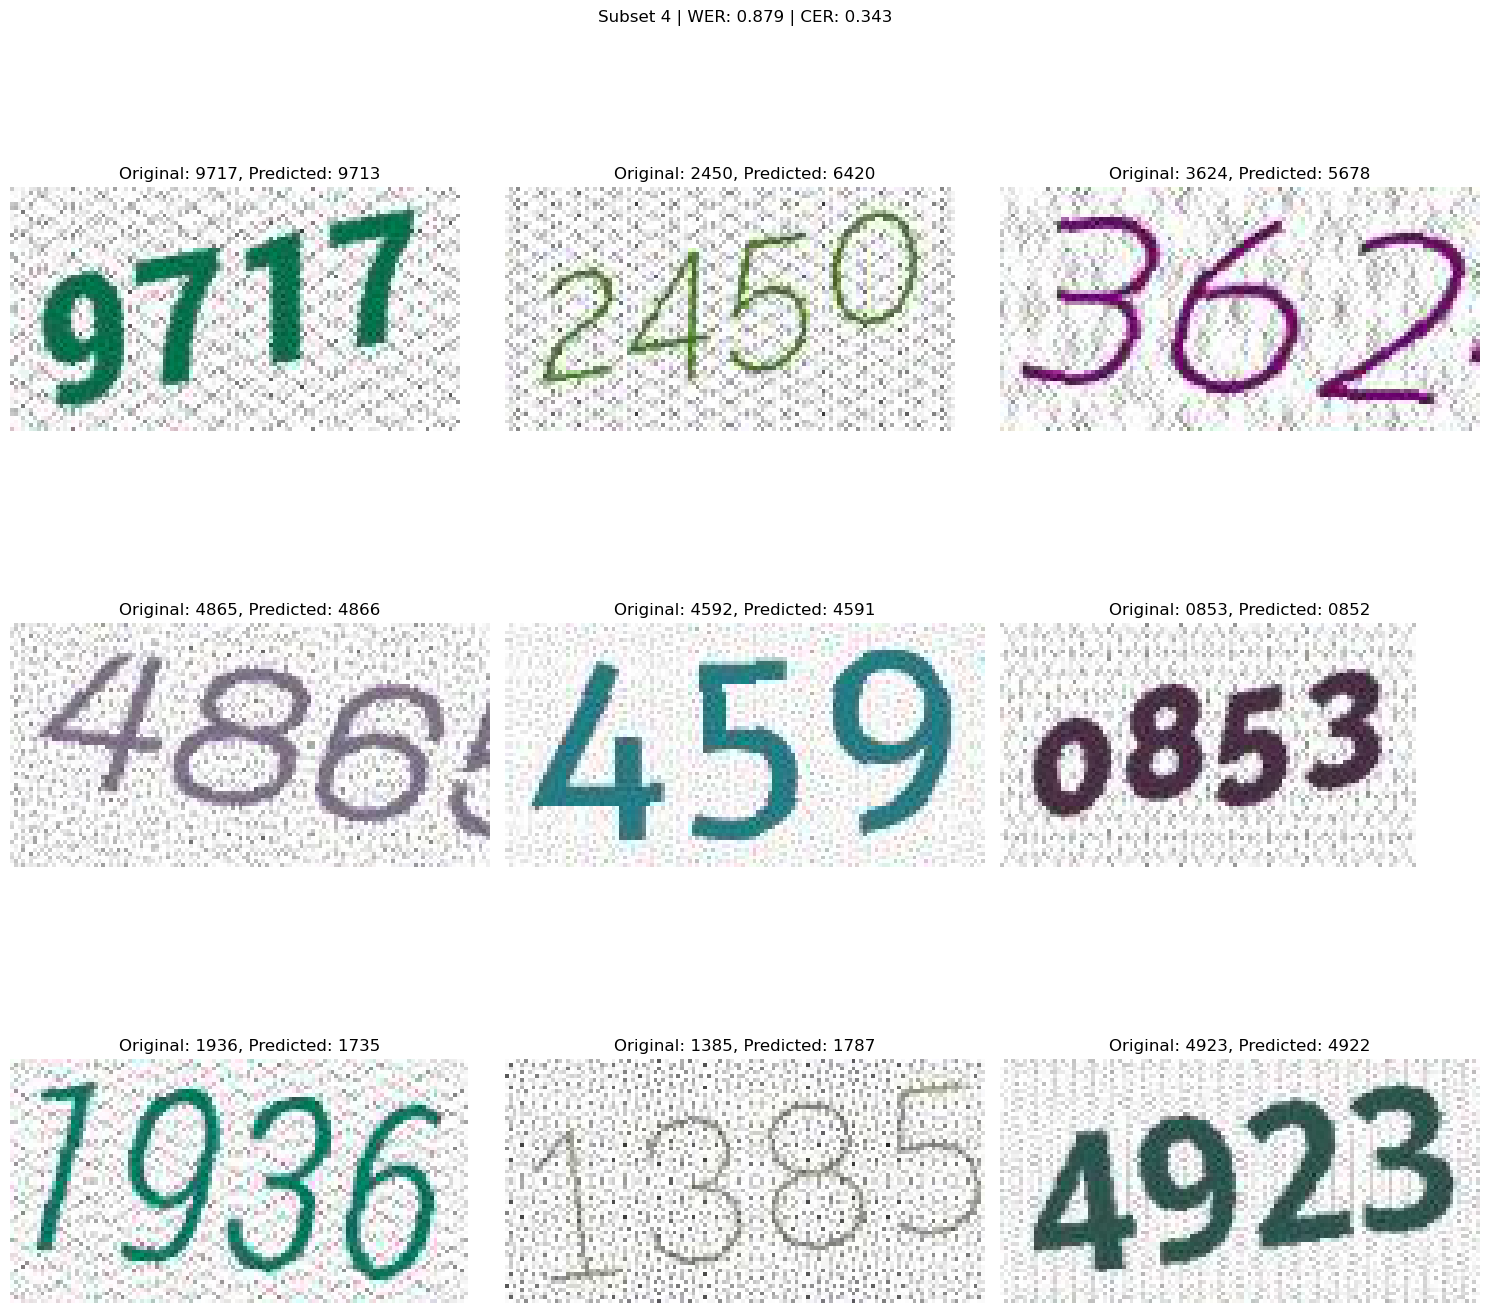

In [10]:
plot_errors(res4, 4)

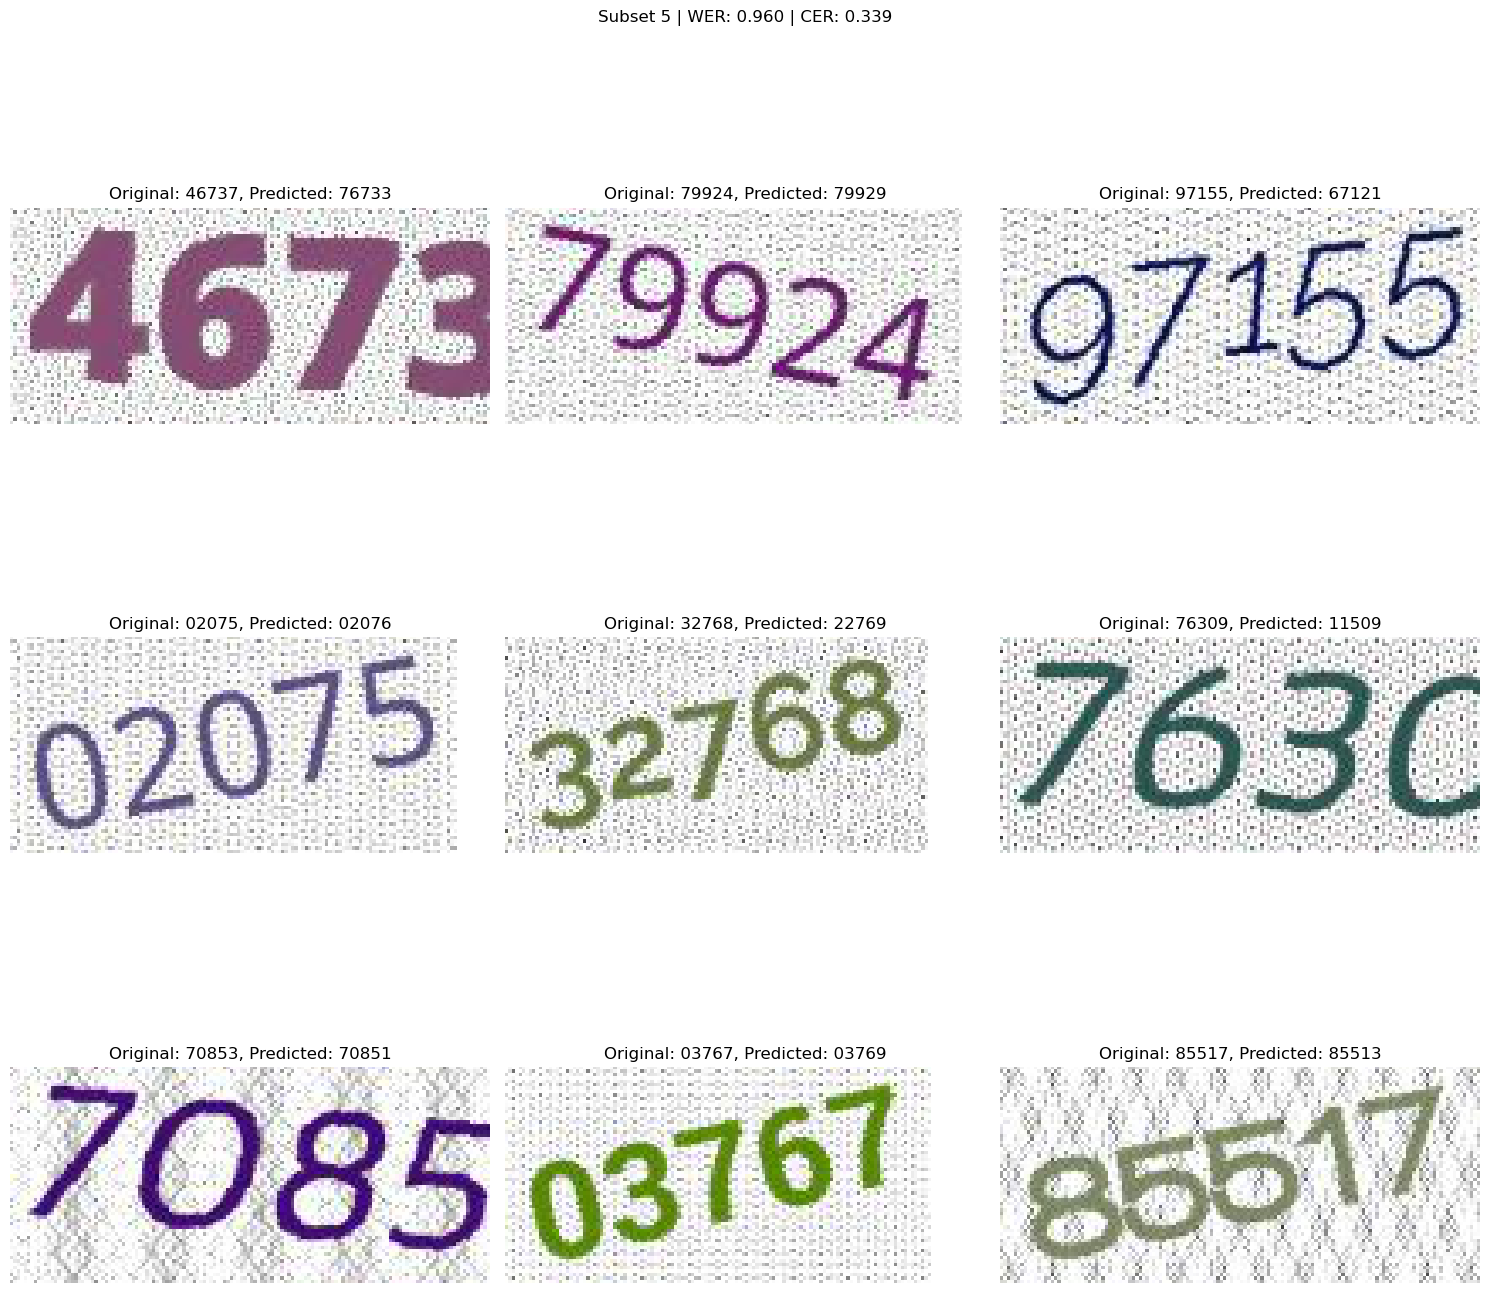

In [11]:
plot_errors(res5, 5)